In [111]:
!pip install ydata_profiling
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import scipy.stats as stats

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

from ydata_profiling import ProfileReport
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_curve, auc
from catboost import Pool, CatBoostClassifier

import eli5
from eli5.sklearn import PermutationImportance

/kaggle/input/babies-birth-weight/babies.csv


In [112]:
import warnings
warnings.filterwarnings("ignore")

# Pre_info: gestation age is definitely connected to the body weight of infants, so I don't consider it as a thesis of this reserchment. 

In [113]:
import lightgbm as lgb
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

In [114]:
df = pd.read_csv('/kaggle/input/babies-birth-weight/babies.csv', index_col='case')
df

,bwt,gestation,parity,age,height,weight,smoke
case,,,,,,,
1,120,284.0,0,27.0,62.0,100.0,0.0
2,113,282.0,0,33.0,64.0,135.0,0.0
3,128,279.0,0,28.0,64.0,115.0,1.0
4,123,NaN,0,36.0,69.0,190.0,0.0
5,108,282.0,0,23.0,67.0,125.0,1.0
...,...,...,...,...,...,...,...
1232,113,275.0,1,27.0,60.0,100.0,0.0
1233,128,265.0,0,24.0,67.0,120.0,0.0
1234,130,291.0,0,30.0,65.0,150.0,1.0


**We have 7 features, 5 numeric (bwt, gestation, age, height, weight) and 2 categorical (smoke, parity). The most interesting feature is birth weight due to the fact that it is highly connected with futher condition of a newborn and their quality of life.**

In [115]:
#imperial into metric system
df['height'] = df['height'] * 0.0254
df['weight'] = df['weight'] * 0.45359237
df['bwt'] = df['bwt'] * 28.34952

**We translate the imperial system of measures into metric for the convenience of analysis**

In [116]:
profile = ProfileReport(df, title="Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [117]:
df = df.dropna(subset=['gestation', 'age', 'smoke']) 
df['height'] = df['height'].fillna(df['height'].mean())
df['weight'] = df['weight'].fillna(df['weight'].mean())
df.isna().sum()

bwt          0
gestation    0
parity       0
age          0
height       0
weight       0
smoke        0
dtype: int64

**Since 'gestation' and 'smoke' are signs that depend on the course of labor and the condition of the mother, filling them with an average or something else is incorrect. there are not so many of them, so they can be removed from the dataset without much loss.**

**The height and weight of mothers, on the contrary, are signs surrounding the average in the population, so they can be replaced by an average.**

In [118]:
df['bwt'].describe()

count    1211.000000
mean     3389.628736
std       516.701674
min      1559.223600
25%      3075.922920
50%      3401.942400
75%      3713.787120
max      4989.515520
Name: bwt, dtype: float64

Text(0.5, 1.0, 'Count of the newborns in each defined class')

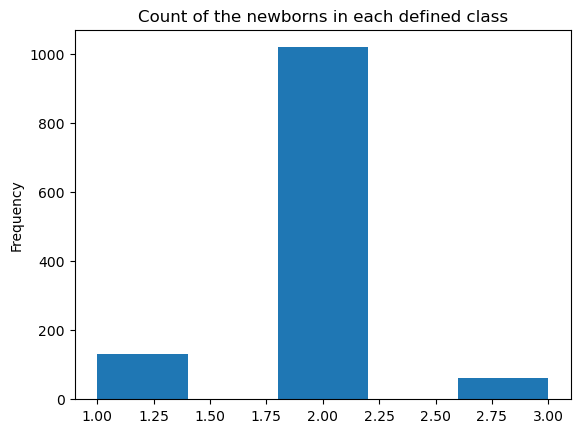

In [119]:
colors = sns.color_palette("deep")

conditions = [
    (df['bwt'] > 4000),
    (df['bwt'] <= 4000) & (df['bwt'] >= 2500),
    (df['bwt'] < 2500) & (df['bwt'] > 1500),
    (df['bwt'] < 1500) & (df['bwt'] > 1000),
    (df['bwt'] < 1000)
             ]
values = [1, 2, 3, 4, 5]
values_names = ['Macrosomia', 'Normal weight', 'Low body weight', 'Very low body weight', 'Extremely low body weight']
#Macrosomia = 1, Normal weight = 2, Low body weight = 3, Very low body weight = 4, Extremely low body weight = 5

df['bwt_class'] = np.select(conditions, values)
df['bwt_class'].plot(kind='hist', bins=5)
plt.title('Count of the newborns in each defined class')

**Since there is a weak negative correlation between the smoking of the mother and the weight of the newborn, we will try to train the model to predict the weight class of the newborn according to the given signs. But to do this, we will check in advance whether there are observations among mothers with increased body weight (BMI).**

count    1211.000000
mean       22.007687
std         3.183433
min        15.662053
25%        19.968840
50%        21.305139
75%        23.296980
max        40.350642
Name: bmi, dtype: float64

<AxesSubplot:>

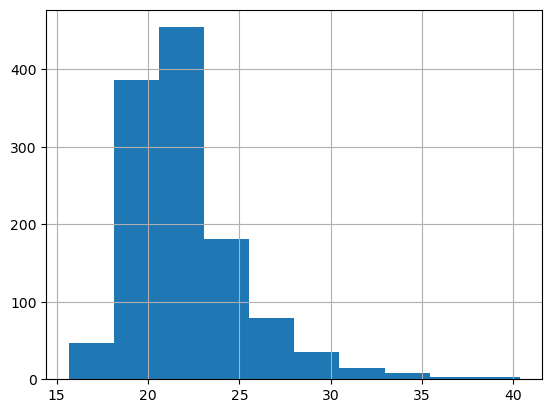

In [120]:
df['bmi'] = df['weight'] / (df['height'] ** 2)
display(df.bmi.describe())
df.bmi.hist()

In [121]:
df['bwt'].corr(df['bmi'])

0.0606552340381597

There are overwieght, obese and extremely o. mothers, but there is no connection between BMI and birth weight.

0.4051397570304744

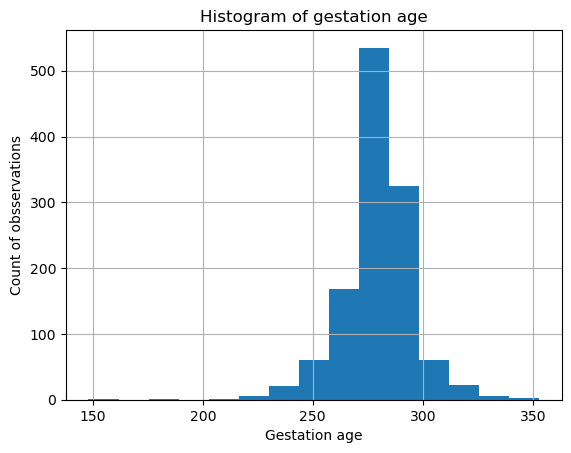

In [122]:
df['gestation'].hist(bins=15)
plt.title('Histogram of gestation age')
plt.xlabel('Gestation age')
plt.ylabel('Count of obsservations')
df.gestation.describe()
df['gestation'].corr(df['bwt'])

There are few extremely preterm infants in data. Also the correlation between gestation and birth weight is high, that may have influence on the results of classification.

In [123]:
conditions = (
    (df['gestation'] < 259),
    (df['gestation'] > 259) & (df['gestation'] < 293),
    (df['gestation'] > 293)
)

variables = (0, 1, 2)

df['normal_gestation'] = np.select(conditions, variables)

df.head()

,bwt,gestation,parity,age,height,weight,smoke,bwt_class,bmi,normal_gestation
case,,,,,,,,,,
1,3401.94240,284.0,0,27.0,1.5748,45.359237,0.0,2,18.290051,1
2,3203.49576,282.0,0,33.0,1.6256,61.234970,0.0,2,23.172459,1
3,3628.73856,279.0,0,28.0,1.6256,52.163123,1.0,2,19.739502,1
5,3061.74816,282.0,0,23.0,1.7018,56.699046,1.0,2,19.577567,1
6,3855.53472,286.0,0,25.0,1.5748,42.184090,0.0,2,17.009748,1


count    936.000000
mean     278.643162
std        7.806265
min      260.000000
25%      273.000000
50%      279.000000
75%      285.000000
max      292.000000
Name: gestation, dtype: float64

count     936.000000
mean     3400.912610
std       472.690747
min      2012.815920
25%      3090.097680
50%      3401.942400
75%      3685.437600
max      4932.816480
Name: bwt, dtype: float64

Text(0, 0.5, 'Count of observations')

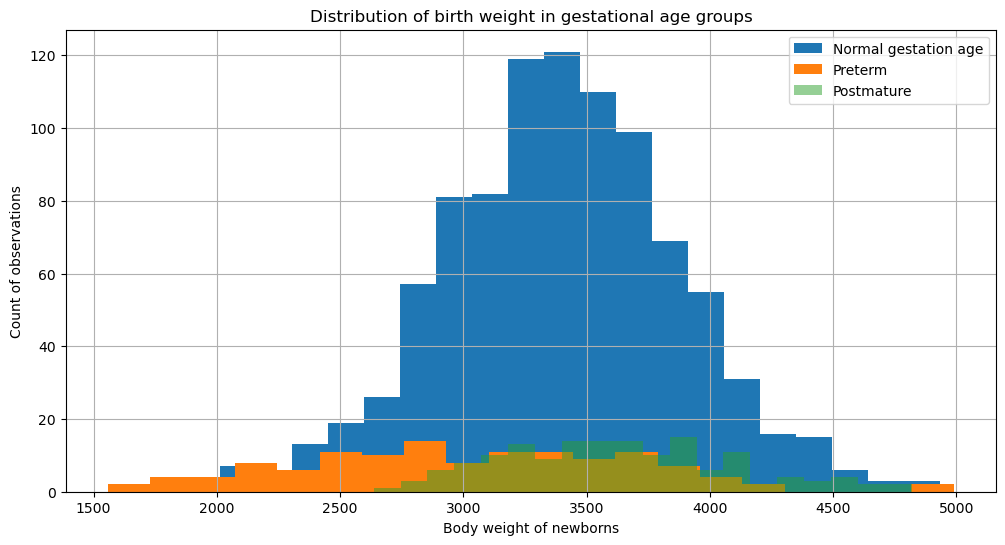

In [124]:
df[df['normal_gestation'] == 1]['bwt'].hist(bins=20, figsize=(12,6))
df[df['normal_gestation'] == 0]['bwt'].hist(bins=20)
df[df['normal_gestation'] == 2]['bwt'].hist(bins=20, alpha=0.5)
display(df[df['normal_gestation'] == 1]['gestation'].describe(),
        df[df['normal_gestation'] == 1]['bwt'].describe()
       )
plt.legend(['Normal gestation age', 'Preterm', 'Postmature'])
plt.title('Distribution of birth weight in gestational age groups')
plt.xlabel('Body weight of newborns')
plt.ylabel('Count of observations')

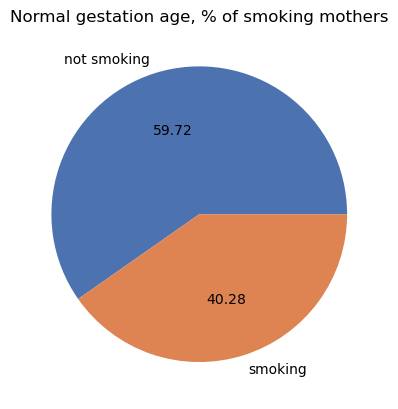

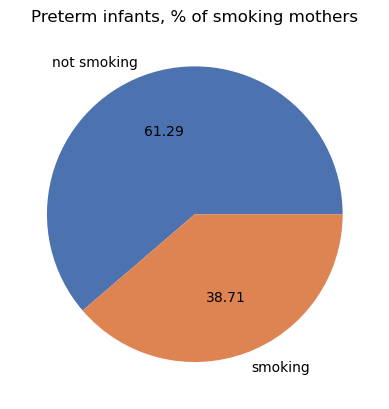

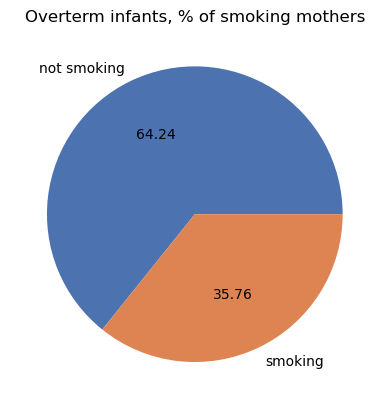

In [125]:
preterm = df[df['normal_gestation'] == 0]
norm = df[df['normal_gestation'] == 1]
overterm = df[df['normal_gestation'] == 2]
norm['smoke'] = norm['smoke'].astype(int)
preterm['smoke'] = preterm['smoke'].astype(int)
overterm['smoke'] = overterm['smoke'].astype(int)

norm_g = norm.groupby(by='smoke').count()
labels = ['not smoking', 'smoking']
plt.pie(norm_g['bwt'], labels=labels, autopct='%.2f', colors = colors)
plt.title('Normal gestation age, % of smoking mothers')
plt.show()

preterm_g = preterm.groupby(by='smoke').count()
labels = ['not smoking', 'smoking']
plt.pie(preterm_g['bwt'], labels=labels, autopct='%.2f', colors = colors)
plt.title('Preterm infants, % of smoking mothers')
plt.show()

overterm_g = overterm.groupby(by='smoke').count()
labels = ['not smoking', 'smoking']
plt.pie(overterm_g['bwt'], labels=labels, autopct='%.2f', colors = colors)
plt.title('Overterm infants, % of smoking mothers')
plt.show()

Intresting fact that there are more smokers in group of normal gestation age than in groupes under and over the normal gestation age.

May be there is a connection between birth weight and smoking?

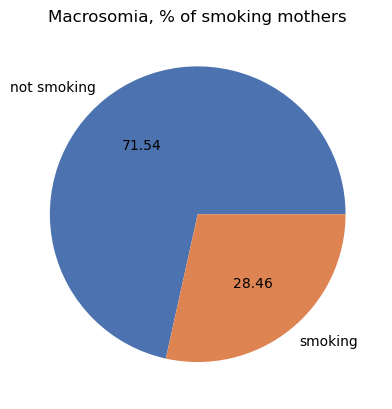

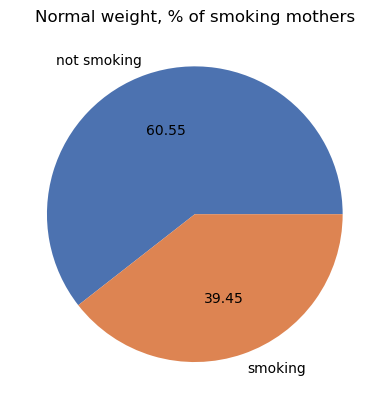

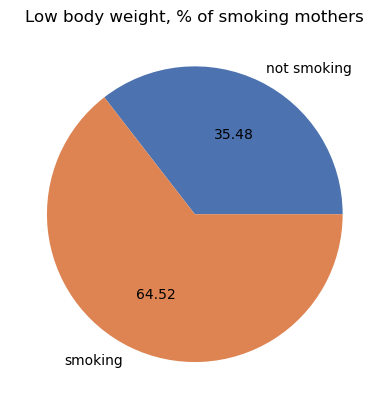

In [126]:
macro = (df[df['bwt_class'] == 1]).groupby(by='smoke').count()
plt.pie(macro['bwt'], labels=labels, autopct='%.2f', colors = colors)
plt.title('Macrosomia, % of smoking mothers')
plt.show()

normal_weight = (df[df['bwt_class'] == 2]).groupby(by='smoke').count()
plt.pie(normal_weight['bwt'], labels=labels, autopct='%.2f', colors = colors)
plt.title('Normal weight, % of smoking mothers')
plt.show()

lbw = (df[df['bwt_class'] == 3]).groupby(by='smoke').count()
plt.pie(lbw['bwt'], labels=labels, autopct='%.2f', colors = colors)
plt.title('Low body weight, % of smoking mothers')
plt.show()

Hypothesis Formulation:
* Null Hypothesis (H0): Smoking has no effect on the likelihood of having a baby with a low body weight.
* Alternative Hypothesis (HA): Smoking increases the likelihood of having a baby with a low body weight.

In [127]:
#do get rid of non-binary classification let's make macrosomal children 
#a part of Normal Weight, so we're answering the question
#if the parameters we have can influence the bwt class of the child?
#and can we predict the class according to these data
display(df.groupby('bwt_class').count())

conditions = (
    (df['bwt_class'] == 1),
    (df['bwt_class'] == 2),
    (df['bwt_class'] == 3),
)

variables = (0, 0, 1)

df['bwt_class'] = np.select(conditions, variables)

df.groupby('bwt_class').count()

,bwt,gestation,parity,age,height,weight,smoke,bmi,normal_gestation
bwt_class,,,,,,,,,
1,130,130,130,130,130,130,130,130,130
2,1019,1019,1019,1019,1019,1019,1019,1019,1019
3,62,62,62,62,62,62,62,62,62


,bwt,gestation,parity,age,height,weight,smoke,bmi,normal_gestation
bwt_class,,,,,,,,,
0,1149,1149,1149,1149,1149,1149,1149,1149,1149
1,62,62,62,62,62,62,62,62,62


In [128]:
df['smoke'] = df['smoke'].astype(int)
df['gestation']= df['gestation'].astype(int)
df['age']= df['age'].astype(int)
df.head()

,bwt,gestation,parity,age,height,weight,smoke,bwt_class,bmi,normal_gestation
case,,,,,,,,,,
1,3401.94240,284,0,27,1.5748,45.359237,0,0,18.290051,1
2,3203.49576,282,0,33,1.6256,61.234970,0,0,23.172459,1
3,3628.73856,279,0,28,1.6256,52.163123,1,0,19.739502,1
5,3061.74816,282,0,23,1.7018,56.699046,1,0,19.577567,1
6,3855.53472,286,0,25,1.5748,42.184090,0,0,17.009748,1


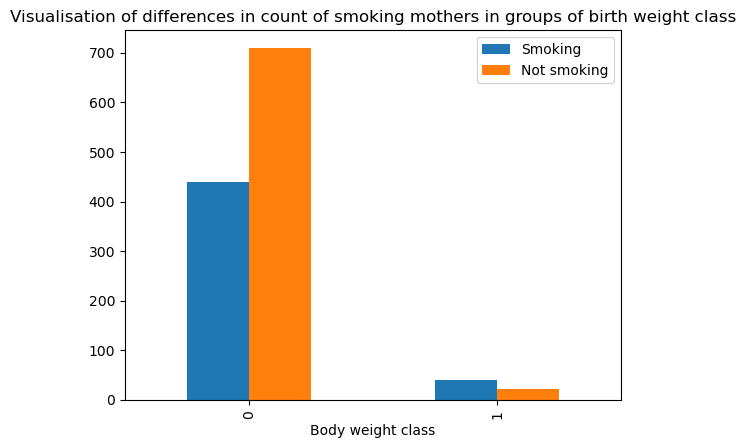

In [129]:
smokers = df.loc[df['smoke'] == 1, 'bwt_class']
not_smokers = df.loc[df['smoke'] == 0, 'bwt_class']
smokers_Chi = pd.DataFrame(smokers).groupby(by='bwt_class').size()
not_smokers_Chi = pd.DataFrame(not_smokers).groupby(by='bwt_class').size()
contingency_table = pd.concat([smokers_Chi, not_smokers_Chi], axis=1)
contingency_table.plot(kind='bar')
plt.title('Visualisation of differences in count of smoking mothers in groups of birth weight class')
plt.legend(['Smoking', 'Not smoking'])
plt.xlabel('Body weight class')
plt.show()

Differences in groups are visible on plot. To prove them let's use $χ^2$ test.

In [130]:
contingency_table = contingency_table.to_numpy().T

# Perform the chi-square test
chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)

# Set the significance level
alpha = 0.05

# Print the results
print("Contingency Table:")
print(contingency_table)
print("\nChi-square statistic:", chi2)
print("p-value:", p_value)

if p_value < alpha:
    print("\nReject the null hypothesis.")
    print("There is a significant association between smoking and low body weight.")
else:
    print("\nFail to reject the null hypothesis.")
    print("There is insufficient evidence to conclude an association between smoking and low body weight.")

Contingency Table:
[[439  40]
 [710  22]]

Chi-square statistic: 15.94750661371456
p-value: 6.512350402416024e-05

Reject the null hypothesis.
There is a significant association between smoking and low body weight.


# After the fast EDA we can see that:
1. There are both premature, preterm & low weighted children and premature macrosomic children.
2. There are connected features (such as gestation and birth weight) that can influence the quality of the model.
3. Smoking can be connected with the birth weight, so this feature is more relevant than gestation.

Taking into account the above factors, we will set the problem as a classification by birth weight. I do not see the point in dividing into full-term, postmature and premature yet, though there can be other factors that influence on early labours. 

To see which data if more relevant for this classification we'll make a few different dataframes.

In [131]:
RS = np.random.RandomState(12345)
CV = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=RS)

my_df_features = df[['parity', 'smoke', 'bmi', 'age']]
my_df_target = df['bwt_class']

features_train, features_test, target_train, target_test = train_test_split(my_df_features, 
                                                                            my_df_target, 
                                                                            test_size=0.2, 
                                                                            stratify=my_df_target)

In [132]:
scaler = StandardScaler()
numeric = ['bmi', 'age']
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [133]:
%%time

model_lgbm = lgb.LGBMClassifier(verbose=-1, random_state=RS)

params_lgbm = {'learning_rate': np.arange(0.001, 0.03),
               'n_estimators': range(200, 300),
               'num_leaves': range(100, 250),
               'max_depth': range(2,10),
               'class_weight': ["balanced"]
              }

grid_lgbm = RandomizedSearchCV(
    model_lgbm,
    params_lgbm, 
    n_jobs=-1,
    scoring='f1',
    cv=CV
)

grid_lgbm.fit(features_train, target_train)
display(f'best_score: {grid_lgbm.best_score_}')
display(f'best_params: {grid_lgbm.best_params_}')

'best_score: 0.15812267607938912'

"best_params: {'num_leaves': 212, 'n_estimators': 221, 'max_depth': 2, 'learning_rate': 0.001, 'class_weight': 'balanced'}"

CPU times: user 2.3 s, sys: 96 ms, total: 2.4 s
Wall time: 24.6 s


In [134]:
n = pd.DataFrame(grid_lgbm.cv_results_)
n

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_num_leaves,param_n_estimators,param_max_depth,param_learning_rate,param_class_weight,params,...,split23_test_score,split24_test_score,split25_test_score,split26_test_score,split27_test_score,split28_test_score,split29_test_score,mean_test_score,std_test_score,rank_test_score
0,0.221542,0.068129,0.006371,0.002665,211,226,8,0.001,balanced,"{'num_leaves': 211, 'n_estimators': 226, 'max_...",...,0.166667,0.139535,0.064516,0.193548,0.114286,0.093023,0.076923,0.132452,0.063593,3
1,0.159471,0.009976,0.005208,0.000290,167,218,7,0.001,balanced,"{'num_leaves': 167, 'n_estimators': 218, 'max_...",...,0.142857,0.150000,0.054054,0.193548,0.111111,0.090909,0.074074,0.130037,0.064460,4
2,0.116522,0.008160,0.004687,0.000295,114,224,5,0.001,balanced,"{'num_leaves': 114, 'n_estimators': 224, 'max_...",...,0.186047,0.125000,0.060606,0.117647,0.133333,0.090909,0.066667,0.123448,0.065482,6
3,0.147061,0.025017,0.005682,0.001661,153,272,5,0.001,balanced,"{'num_leaves': 153, 'n_estimators': 272, 'max_...",...,0.181818,0.125000,0.058824,0.117647,0.137931,0.086957,0.076923,0.120438,0.063575,7
4,0.075352,0.004986,0.004368,0.000314,216,252,3,0.001,balanced,"{'num_leaves': 216, 'n_estimators': 252, 'max_...",...,0.208333,0.142857,0.097561,0.000000,0.148148,0.114286,0.057143,0.110030,0.056425,9
5,0.129362,0.009747,0.005217,0.001495,194,251,5,0.001,balanced,"{'num_leaves': 194, 'n_estimators': 251, 'max_...",...,0.186047,0.125000,0.058824,0.117647,0.133333,0.086957,0.066667,0.119994,0.063627,8
6,0.048702,0.003471,0.003947,0.000237,212,221,2,0.001,balanced,"{'num_leaves': 212, 'n_estimators': 221, 'max_...",...,0.186047,0.177778,0.095238,0.170213,0.166667,0.157895,0.190476,0.158123,0.048997,1
7,0.195299,0.011567,0.005519,0.000213,163,254,8,0.001,balanced,"{'num_leaves': 163, 'n_estimators': 254, 'max_...",...,0.166667,0.100000,0.060606,0.148148,0.117647,0.090909,0.076923,0.128039,0.060531,5
8,0.079692,0.007045,0.005057,0.002453,152,268,3,0.001,balanced,"{'num_leaves': 152, 'n_estimators': 268, 'max_...",...,0.208333,0.139535,0.051282,0.000000,0.148148,0.114286,0.057143,0.108603,0.057409,10
9,0.074734,0.018011,0.005842,0.002771,100,290,2,0.001,balanced,"{'num_leaves': 100, 'n_estimators': 290, 'max_...",...,0.186047,0.177778,0.095238,0.170213,0.166667,0.125000,0.190476,0.157351,0.049034,2


In [135]:
pred_lgbm = grid_lgbm.predict(features_test)
display(roc_auc_score(target_test, pred_lgbm))

0.5443722943722944

In [136]:
df_features_1 = df[['parity', 'smoke', 'height', 'weight', 'age']]
my_df_target_1 = df['bwt_class']

features_train, features_test, target_train, target_test = train_test_split(df_features_1, 
                                                                            my_df_target_1, 
                                                                            test_size=0.2, 
                                                                            stratify=my_df_target)

In [137]:
%%time

model_lgbm = lgb.LGBMClassifier(verbose=-1, random_state=RS)

params_lgbm = {"gpu_platform_id": [0],
               "gpu_device_id": [0],
               'learning_rate': np.arange(0.001, 0.03),
               'n_estimators': range(200, 300),
               'num_leaves': range(100, 250),
               'max_depth': range(2,10),
               'class_weight': ["balanced"]
              }

grid_lgbm = RandomizedSearchCV(
    model_lgbm,
    params_lgbm, 
    n_jobs=-1,
    scoring='f1',
    cv=CV
)

grid_lgbm.fit(features_train, target_train)
display(f'best_score: {grid_lgbm.best_score_}')
display(f'best_params: {grid_lgbm.best_params_}')

'best_score: 0.14265899414290914'

"best_params: {'num_leaves': 226, 'n_estimators': 297, 'max_depth': 8, 'learning_rate': 0.001, 'gpu_platform_id': 0, 'gpu_device_id': 0, 'class_weight': 'balanced'}"

CPU times: user 2.03 s, sys: 58.2 ms, total: 2.09 s
Wall time: 19.2 s


In [138]:
n = pd.DataFrame(grid_lgbm.cv_results_)
display(n)

pred_lgbm = grid_lgbm.predict(features_test)
display(roc_auc_score(target_test, pred_lgbm))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_num_leaves,param_n_estimators,param_max_depth,param_learning_rate,param_gpu_platform_id,param_gpu_device_id,...,split23_test_score,split24_test_score,split25_test_score,split26_test_score,split27_test_score,split28_test_score,split29_test_score,mean_test_score,std_test_score,rank_test_score
0,0.062290,0.004362,0.004795,0.001807,202,209,3,0.001,0,0,...,0.142857,0.041667,0.000000,0.153846,0.122449,0.156863,0.102564,0.106828,0.049170,8
1,0.062898,0.003950,0.004320,0.000469,106,299,2,0.001,0,0,...,0.166667,0.037037,0.068966,0.142857,0.200000,0.139535,0.131148,0.122678,0.051492,6
2,0.101140,0.007799,0.005055,0.000978,226,265,4,0.001,0,0,...,0.146341,0.066667,0.000000,0.162162,0.157895,0.216216,0.148148,0.136516,0.054071,5
3,0.181098,0.010326,0.005532,0.000478,243,253,8,0.001,0,0,...,0.181818,0.068966,0.066667,0.137931,0.162162,0.250000,0.187500,0.140381,0.065066,3
4,0.072795,0.004984,0.004412,0.000368,227,259,3,0.001,0,0,...,0.142857,0.046512,0.000000,0.157895,0.122449,0.156863,0.102564,0.103031,0.045738,9
5,0.051838,0.005612,0.004438,0.001058,214,229,2,0.001,0,0,...,0.166667,0.032787,0.068966,0.142857,0.256410,0.142857,0.131148,0.122595,0.054408,7
6,0.075702,0.009900,0.005101,0.001954,114,255,3,0.001,0,0,...,0.142857,0.043478,0.000000,0.157895,0.122449,0.156863,0.102564,0.102929,0.045866,10
7,0.140474,0.040055,0.007406,0.003506,190,237,4,0.001,0,0,...,0.156863,0.060606,0.000000,0.162162,0.181818,0.222222,0.148148,0.138955,0.055493,4
8,0.191380,0.011608,0.005541,0.001210,165,263,8,0.001,0,0,...,0.181818,0.071429,0.066667,0.142857,0.162162,0.250000,0.187500,0.140734,0.065260,2
9,0.220264,0.022294,0.005829,0.001604,226,297,8,0.001,0,0,...,0.176471,0.071429,0.064516,0.142857,0.162162,0.242424,0.193548,0.142659,0.066417,1


0.5238095238095237

# May be I should do bootstrapping to reach significant metric?

In [139]:
from sklearn.utils import resample

In [140]:
nbw = df[df['bwt_class'] == 0]
lbw = df[df['bwt_class'] == 1]

display(f"Normal body weight class is {round(nbw.count()['bwt'] / lbw.count()['bwt'], 1)} times more frequent then low body weight")

'Normal body weight class is 18.5 times more frequent then low body weight'

In [141]:
lbw_upsample = resample(lbw,
             replace=True,
             n_samples=len(nbw),
             random_state=RS)

print(lbw_upsample.shape, nbw.shape)

(1149, 10) (1149, 10)


In [142]:
new_df = pd.concat([nbw, lbw_upsample])
new_df.groupby(by='bwt_class').count()

,bwt,gestation,parity,age,height,weight,smoke,bmi,normal_gestation
bwt_class,,,,,,,,,
0,1149,1149,1149,1149,1149,1149,1149,1149,1149
1,1149,1149,1149,1149,1149,1149,1149,1149,1149


In [143]:
df_features_2 = new_df[['parity', 'smoke', 'height', 'weight', 'age']]
df_target_2 = new_df['bwt_class']

features_train, features_test, target_train, target_test = train_test_split(df_features_2, 
                                                                            df_target_2, 
                                                                            test_size=0.2)

In [144]:
%%time

model_lgbm = lgb.LGBMClassifier(random_state=RS)

params_lgbm = {'learning_rate': np.arange(0.001, 0.03),
               'n_estimators': range(200, 300),
               'num_leaves': range(100, 250),
               'max_depth': range(2,10),
               'verbose': [-1]
              }

grid_lgbm = RandomizedSearchCV(
    model_lgbm,
    params_lgbm, 
    n_jobs=-1,
    scoring='f1',
    cv=CV
)

grid_lgbm.fit(features_train, target_train)
display(f'best_score: {grid_lgbm.best_score_}')
display(f'best_params: {grid_lgbm.best_params_}')

'best_score: 0.8236362144847929'

"best_params: {'verbose': -1, 'num_leaves': 200, 'n_estimators': 226, 'max_depth': 9, 'learning_rate': 0.001}"

CPU times: user 3.24 s, sys: 106 ms, total: 3.35 s
Wall time: 41.1 s


In [145]:
n = pd.DataFrame(grid_lgbm.cv_results_)
display(n)

pred_lgbm = grid_lgbm.predict(features_test)
display(roc_auc_score(target_test, pred_lgbm))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_verbose,param_num_leaves,param_n_estimators,param_max_depth,param_learning_rate,params,...,split23_test_score,split24_test_score,split25_test_score,split26_test_score,split27_test_score,split28_test_score,split29_test_score,mean_test_score,std_test_score,rank_test_score
0,0.285544,0.042476,0.006908,0.001620,-1,243,207,9,0.001,"{'verbose': -1, 'num_leaves': 243, 'n_estimato...",...,0.800000,0.874372,0.774510,0.787234,0.838384,0.830601,0.822222,0.823222,0.030807,2
1,0.105473,0.003378,0.005470,0.000325,-1,125,298,3,0.001,"{'verbose': -1, 'num_leaves': 125, 'n_estimato...",...,0.659574,0.731278,0.673469,0.651934,0.662983,0.694737,0.571429,0.667027,0.040844,10
2,0.338551,0.015097,0.007162,0.000440,-1,133,297,7,0.001,"{'verbose': -1, 'num_leaves': 133, 'n_estimato...",...,0.790476,0.858537,0.764706,0.783920,0.828571,0.812834,0.770053,0.812390,0.031990,5
3,0.303127,0.040957,0.006881,0.000439,-1,171,269,7,0.001,"{'verbose': -1, 'num_leaves': 171, 'n_estimato...",...,0.790476,0.859903,0.764706,0.783920,0.828571,0.812834,0.765957,0.809022,0.033667,6
4,0.247489,0.028194,0.006645,0.001359,-1,179,213,8,0.001,"{'verbose': -1, 'num_leaves': 179, 'n_estimato...",...,0.800000,0.880000,0.756219,0.804124,0.838095,0.822917,0.760234,0.816092,0.038579,4
5,0.392734,0.110253,0.007981,0.002020,-1,223,260,8,0.001,"{'verbose': -1, 'num_leaves': 223, 'n_estimato...",...,0.800000,0.881188,0.760000,0.804124,0.838095,0.822917,0.781609,0.818392,0.035205,3
6,0.180015,0.007042,0.006630,0.001148,-1,247,299,5,0.001,"{'verbose': -1, 'num_leaves': 247, 'n_estimato...",...,0.747826,0.779817,0.707071,0.702128,0.743961,0.760976,0.775510,0.764756,0.028775,9
7,0.184131,0.006162,0.006650,0.001665,-1,180,239,6,0.001,"{'verbose': -1, 'num_leaves': 180, 'n_estimato...",...,0.777778,0.840000,0.728205,0.707692,0.766839,0.793651,0.769231,0.772051,0.037260,8
8,0.208616,0.019686,0.007029,0.002646,-1,115,211,7,0.001,"{'verbose': -1, 'num_leaves': 115, 'n_estimato...",...,0.790476,0.854369,0.764706,0.775510,0.828571,0.812834,0.765957,0.805224,0.035062,7
9,0.324223,0.015548,0.006464,0.000580,-1,200,226,9,0.001,"{'verbose': -1, 'num_leaves': 200, 'n_estimato...",...,0.800000,0.874372,0.774510,0.778947,0.844221,0.840426,0.822222,0.823636,0.033283,1


0.8680851063829788

In [146]:
control_lgbm = lgb.LGBMClassifier(verbose=-1, 
                                  random_state=RS, 
                                  num_leaves = 123, 
                                  n_estimators = 234, 
                                  max_depth = 9, 
                                  learning_rate = 0.001)

control_lgbm.fit(features_train, target_train)
res = control_lgbm.predict(features_test)
display(roc_auc_score(target_test, res))

0.8680851063829788

In [147]:
perm_lgbm = PermutationImportance(control_lgbm, random_state=RS).fit(features_train, target_train)
eli5.show_weights(perm_lgbm, feature_names=features_train.columns.tolist())

Weight,Feature
0.2374 ± 0.0209,weight
0.2113 ± 0.0075,smoke
0.1369 ± 0.0150,age
0.1244 ± 0.0146,height
0.0069 ± 0.0018,parity


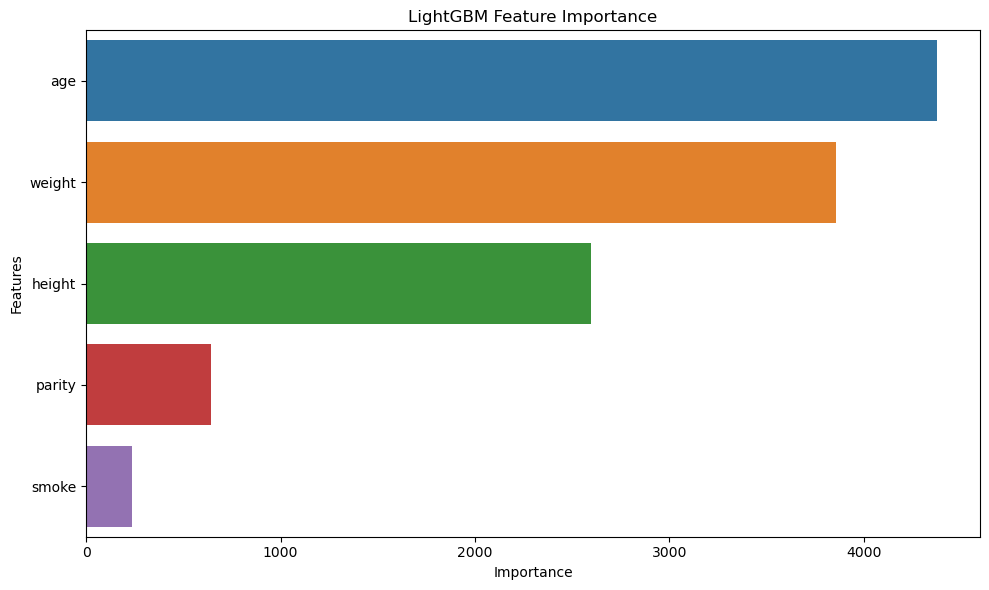

In [148]:
# Obtain feature importances
importances = control_lgbm.feature_importances_
feature_names = features_train.columns

# Create a dataframe with feature importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the dataframe by importance values
importance_df = importance_df.sort_values('Importance', ascending=False)

# Plot the feature importances using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('LightGBM Feature Importance')
plt.tight_layout()
plt.show()

As we can see – smoking is not the most relevant feature, nevertheless,  it does affect the probability of low body weight.
There is still a problem of rising the metric level to reach out weather those % are true.

In [149]:
cat_model = CatBoostClassifier()

cat_params = {'task_type': ["GPU"],
          'learning_rate': np.arange(0.001, 0.1),
          'l2_leaf_reg': range(1,10),
          'max_depth': range(2,10),
          'n_estimators': range(100,250),
          'logging_level': ['Silent']}

rscv_cat = RandomizedSearchCV(
    cat_model,
    cat_params,
    scoring='roc_auc',
    cv=CV,
    verbose=False
)

rscv_cat.fit(features_train, target_train)
display(f'best_score: {rscv_cat.best_score_}')
display(f'best_params: {rscv_cat.best_params_}')

'best_score: 0.8617039940752513'

"best_params: {'task_type': 'GPU', 'n_estimators': 181, 'max_depth': 8, 'logging_level': 'Silent', 'learning_rate': 0.001, 'l2_leaf_reg': 8}"

In [150]:
n_cat = pd.DataFrame(rscv_cat.cv_results_)
display(n_cat)

pred_cat = rscv_cat.predict(features_test)
display(roc_auc_score(target_test, pred_cat))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_task_type,param_n_estimators,param_max_depth,param_logging_level,param_learning_rate,param_l2_leaf_reg,...,split23_test_score,split24_test_score,split25_test_score,split26_test_score,split27_test_score,split28_test_score,split29_test_score,mean_test_score,std_test_score,rank_test_score
0,1.090401,0.141243,0.006847,0.001111,GPU,167,3,Silent,0.001,7,...,0.730710,0.722826,0.759216,0.739839,0.706640,0.744207,0.801541,0.751436,0.028887,6
1,1.084062,0.060726,0.006922,0.000900,GPU,188,2,Silent,0.001,6,...,0.706782,0.695593,0.747696,0.711011,0.681356,0.720975,0.780220,0.723551,0.030460,9
2,1.680753,0.159359,0.006808,0.002993,GPU,216,2,Silent,0.001,7,...,0.719898,0.701737,0.760810,0.733105,0.685196,0.736025,0.770067,0.733924,0.028725,7
3,1.106183,0.110826,0.006383,0.001553,GPU,194,2,Silent,0.001,4,...,0.709973,0.696716,0.747578,0.711957,0.682302,0.724439,0.777592,0.724780,0.030408,8
4,1.012803,0.077746,0.007372,0.002190,GPU,160,2,Silent,0.001,7,...,0.707019,0.693821,0.744211,0.705045,0.681888,0.715839,0.773292,0.721446,0.030540,10
5,1.209786,0.068235,0.006833,0.001002,GPU,160,5,Silent,0.001,1,...,0.799657,0.806415,0.822543,0.829927,0.782550,0.819637,0.869505,0.819268,0.025474,3
6,1.292185,0.131703,0.007071,0.000750,GPU,131,8,Silent,0.001,8,...,0.842609,0.847767,0.855860,0.856037,0.853025,0.858457,0.913820,0.860570,0.023694,2
7,1.318574,0.085671,0.007257,0.001592,GPU,171,6,Silent,0.001,7,...,0.797530,0.799799,0.818762,0.811850,0.796314,0.815635,0.880614,0.819221,0.025697,4
8,1.590654,0.232209,0.006963,0.000994,GPU,181,8,Silent,0.001,8,...,0.844263,0.845699,0.860822,0.856746,0.852198,0.859890,0.913581,0.861704,0.023457,1
9,0.950494,0.056030,0.006527,0.001496,GPU,113,3,Silent,0.001,5,...,0.732069,0.727257,0.762346,0.741080,0.707172,0.749224,0.797062,0.752310,0.027583,5


0.8377304964539007

In [151]:
cat_model = CatBoostClassifier(task_type='GPU', 
                               n_estimators=237, 
                               max_depth=9, 
                               learning_rate=0.001, 
                               l2_leaf_reg=6,
                               verbose=False)

cat_model.fit(features_train, target_train)
res_cat = cat_model.predict(features_test)
display(roc_auc_score(target_test, res_cat))

0.8842080378250591

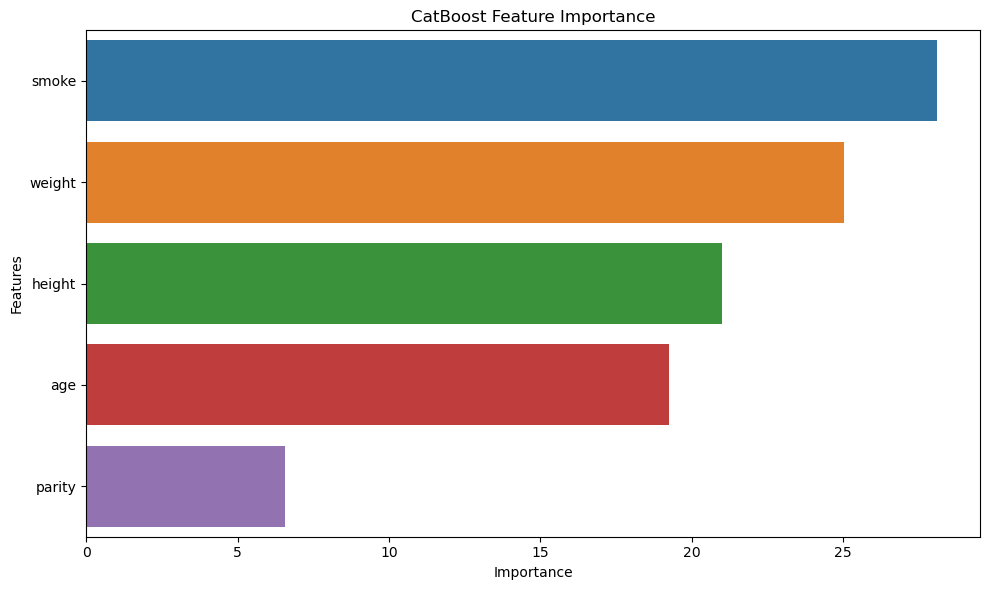

In [152]:
# Obtain feature importances
importances = cat_model.feature_importances_
feature_names = features_train.columns

# Create a dataframe with feature importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the dataframe by importance values
importance_df = importance_df.sort_values('Importance', ascending=False)

# Plot the feature importances using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('CatBoost Feature Importance')
plt.tight_layout()
plt.show()

In [153]:
perm_cat = PermutationImportance(cat_model, random_state=RS).fit(features_train, target_train)
eli5.show_weights(perm_cat, feature_names=features_train.columns.tolist())

Weight,Feature
0.2233 ± 0.0140,weight
0.2220 ± 0.0116,smoke
0.1828 ± 0.0060,height
0.1699 ± 0.0197,age
0.0622 ± 0.0057,parity


In [154]:
from xgboost import XGBClassifier

In [155]:
xgb_model = XGBClassifier()

params_xgb = {
 'learning_rate' : [0.05,0.10,0.15,0.20,0.25,0.30],
 'max_depth': [ 3, 4, 5, 6, 8, 10, 12, 15],
 'min_child_weight' : [ 1, 3, 5, 7 ],
 'gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 'colsample_bytree' : [ 0.3, 0.4, 0.5 , 0.7 ],
 'tree_method': ['gpu_hist']
}

xgb_cv = RandomizedSearchCV(xgb_model,
                            params_xgb,
                            scoring='roc_auc',
                            cv=CV,
                            verbose=False)

xgb_cv.fit(features_train, target_train)
display(f'best_score: {xgb_cv.best_score_}')
display(f'best_params: {xgb_cv.best_params_}')

'best_score: 0.9893367235122068'

"best_params: {'tree_method': 'gpu_hist', 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.25, 'gamma': 0.3, 'colsample_bytree': 0.7}"

In [156]:
xgb_model = XGBClassifier(tree_method='gpu_hist', 
                          min_child_weight= 1, 
                          max_depth= 12, 
                          learning_rate= 0.05, 
                          gamma= 0.0, 
                          colsample_bytree= 0.5)

xgb_model.fit(features_train, target_train)
res_xgb = xgb_model.predict(features_test)
display(roc_auc_score(target_test, res_xgb))

0.9555555555555555

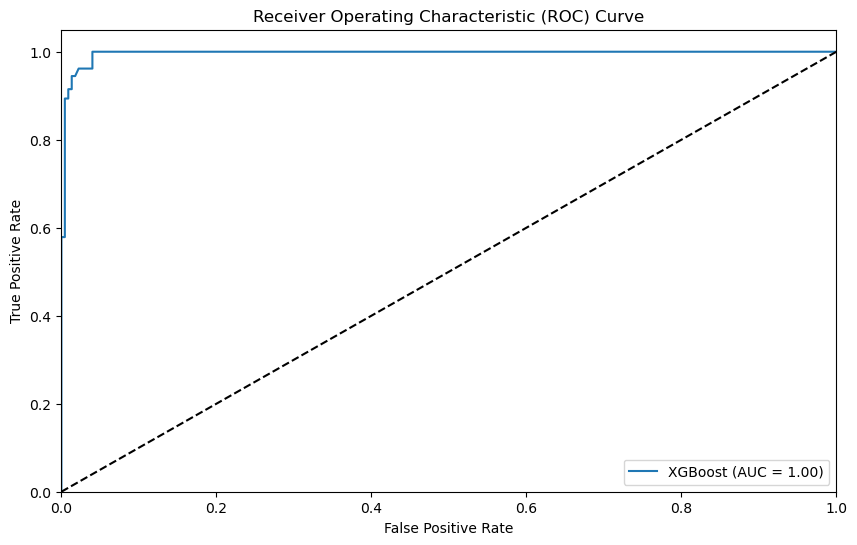

In [157]:
# Compute the false positive rate, true positive rate, and threshold
res_xgb_auc = xgb_model.predict_proba(features_test)[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, res_xgb_auc)

# Compute the AUC score
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label='XGBoost (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

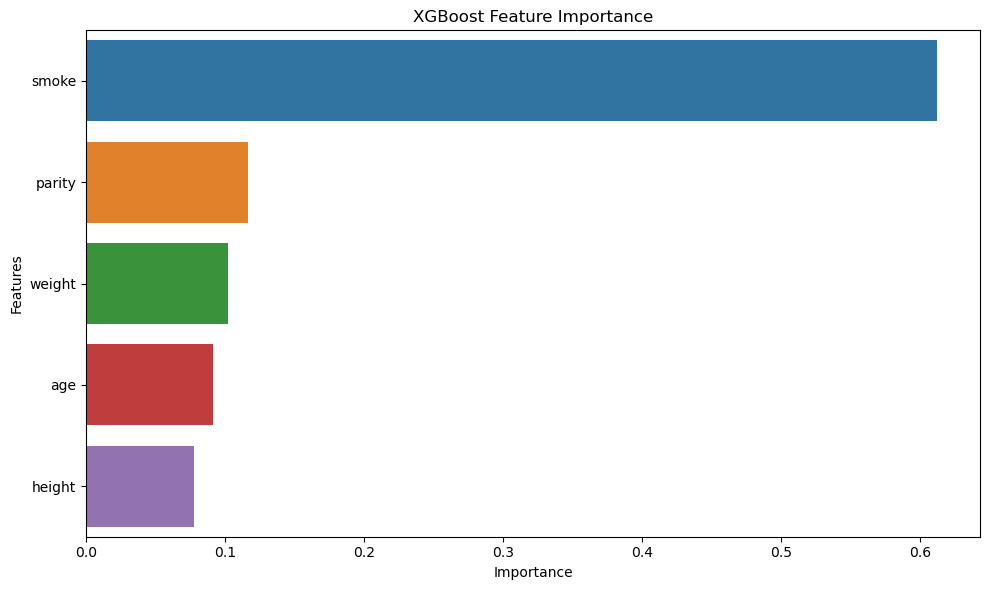

In [158]:
# Obtain feature importances
importances = xgb_model.feature_importances_
feature_names = features_train.columns

# Create a dataframe with feature importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the dataframe by importance values
importance_df = importance_df.sort_values('Importance', ascending=False)

# Plot the feature importances using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

In [159]:
perm_xgb = PermutationImportance(xgb_model, random_state=RS).fit(features_test, target_test)
eli5.show_weights(perm_xgb, feature_names=features_train.columns.tolist())

Weight,Feature
0.3487 ± 0.0162,weight
0.1552 ± 0.0221,height
0.1265 ± 0.0075,smoke
0.1265 ± 0.0245,age
0.0135 ± 0.0043,parity


In [160]:
print('\033[1m' + '1. LGBM PermutationImportance results:\n')
display(eli5.show_weights(perm_lgbm, feature_names=features_train.columns.tolist()))
print('\033[1m' + '\n2. CatBoost PermutationImportance results:\n')
display(eli5.show_weights(perm_cat, feature_names=features_train.columns.tolist()))
print('\033[1m' + '\n3. XGBoost PermutationImportance results:\n')
display(eli5.show_weights(perm_xgb, feature_names=features_train.columns.tolist()))

1. LGBM PermutationImportance results:



Weight,Feature
0.2374 ± 0.0209,weight
0.2113 ± 0.0075,smoke
0.1369 ± 0.0150,age
0.1244 ± 0.0146,height
0.0069 ± 0.0018,parity



2. CatBoost PermutationImportance results:



Weight,Feature
0.2233 ± 0.0140,weight
0.2220 ± 0.0116,smoke
0.1828 ± 0.0060,height
0.1699 ± 0.0197,age
0.0622 ± 0.0057,parity



3. XGBoost PermutationImportance results:



Weight,Feature
0.3487 ± 0.0162,weight
0.1552 ± 0.0221,height
0.1265 ± 0.0075,smoke
0.1265 ± 0.0245,age
0.0135 ± 0.0043,parity


# Conclusions
When analising data, it was found out that children who's mothers smoke have higher chance to be born preterm. 

It was decided to predict class of birth weight due to the fact it influences the futher life quality.

Due to the small amount of data Bootstrapping was performed along with standartization of numeric features.

XGBoost have the best result through all models (96% of correct answers).